In [1]:
from os import listdir
import pandas as pd
base = '/home/snorre/Dropbox/Forskning/bigdata/data_inspections/'
meta_path = base+'simulation_results/metrics/'
meta_path2 = base+'simulation_results/distributions/'

meta_files = [meta_path+i for i in listdir(meta_path)]
dfs = []
for filename in meta_files:
    df = pd.read_csv(filename)
    dfs.append(df)
df = pd.concat(dfs)
df = df.sort_values('modelid')
del dfs

/home/snorre/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/snorre/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [6]:
df.tail()

,alpha,arun_2010,cao_juan_2009,coherence_mimno_2011,griffiths_2004,loglikelihood,modelid,n_iter,n_topics,noise,random_state,simulationNumber
44,0.004348,448.327241,0.089346,-4.269072,-1.444399e+07,-1.434556e+07,8569,1000,230,0.002632,2719,0
45,0.004255,441.997044,0.086358,-4.148864,-1.444785e+07,-1.435582e+07,8570,1000,235,0.002632,1366,0
46,0.004167,434.230948,0.087442,-4.090032,-1.444772e+07,-1.435704e+07,8571,1000,240,0.002632,3158,0
47,0.004082,417.724014,0.083739,-4.168993,-1.445309e+07,-1.434948e+07,8572,1000,245,0.002632,4407,0
48,0.004000,438.453844,0.082208,-4.207269,-1.445156e+07,-1.434610e+07,8573,1000,250,0.002632,3402,0


In [2]:
import pickle

pol_df,noise_df, Index = pickle.load(open(base+'topic_simulation_dependencies.pkl','rb'))

result_path = '/mnt/b0c8e396-e5ba-4614-be6f-146c4c861ab3/data/topic_model_simulation/models/'
model_runs = set(['_'.join(i.split('_')[0:3]) for i in listdir(result_path)])
model_runs = sorted(model_runs,key=lambda x: int(x.split('_')[-1]))
print(len(model_runs))
noise_start_w = 30000
noise_start_d = len(pol_df)


8559


In [3]:
from tqdm import tqdm_notebook as tqdm
import scipy.sparse as sp
addendums = ['doc2topic','w2topic','w2count_topic']
def load_data(model):
    path = result_path+model
    data = []
    for add in addendums:
        filename = path+'_%s.npz'%(add)
        mat = sp.load_npz(filename)
        data.append(mat)#[add] = mat
    return data
import random
data = load_data(random.choice(model_runs))# make sample
data[0],data[1],data[2]

(<47586x55 sparse matrix of type '<class 'numpy.float64'>'
 	with 2617230 stored elements in Compressed Sparse Row format>,
 <55x32399 sparse matrix of type '<class 'numpy.float64'>'
 	with 1781945 stored elements in Compressed Sparse Row format>,
 <55x32399 sparse matrix of type '<class 'numpy.int32'>'
 	with 112697 stored elements in Compressed Sparse Row format>)

In [8]:
#model_runs
sampled_models = df[df.noise==0].groupby('n_topics').apply(lambda x: x.groupby('random_state').apply(lambda x : x.sample(1)))#groupby('n_topics').apply(lambda x: x.sample(5))

In [9]:
paths = []
for modelid in sampled_models.modelid.values:
    path = []
    for i in model_runs:
        if int(i.split('_')[-1]) == int(modelid):
            if float(i.split('_')[1])==0:
                path.append(i)
            #else:
                #print(i)
    if len(path)>1:
        print(1+'2')
    paths.append(path[0])
sampled_models['path'] = paths
subset = sampled_models.drop_duplicates('random_state').groupby('n_topics').apply(lambda x: x.sample(1))#*30000

/home/snorre/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: 'n_topics' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  


In [23]:
#subset.n_topics.values.sum()

In [39]:
### similarity measures

#### Minimum allignment
    ### Do a hard assignment. Locate the documents where the topic is dominant. Quantify the degree to which there is less of the topic in the lower hierachical match?
     ##   -- This is counter factual.
    ### --- also see how much of the top is similar.

#### Min diff between counts of topic assignments. (I.e only count diff when higher hierachy is above 0)


In [42]:
t2d = data[0].toarray()

In [52]:
from collections import Counter
#Counter(t2d.argsort()[:,-1])
d2top = t2d.argsort()[:,-1]
t2c = data[2].toarray()[:,0:30000]
t2c2 = data2[2].toarray()[:,0:30000]

In [10]:
import numpy as np
import scipy.spatial
import networkx as nx

sizes = subset.n_topics.values
topic2topic = np.zeros((subset.n_topics.sum(),subset.n_topics.sum()))
paths = subset.path.values
i_topics = 0 
top2top = nx.DiGraph()

for i in tqdm(range(len(paths)-1)):
    path = paths[i]
    data = load_data(path)
    t2w = data[2].toarray()[:,:30000]
    i_len = t2w.shape[0]
    j_topics = int(i_topics)
    for j in range(i,len(paths)):
        path2 = paths[j]
        data2 = load_data(path2)
        t2w2 = data2[2].toarray()[:,:30000]
        j_len = t2w2.shape[0]
        if i==j:
            j_topics+=j_len
            continue
        cos_mat = 1 - scipy.spatial.distance.cdist(t2w, t2w2, 'cosine')
        
        ### add top match edges:
        #for j_num,val in enumerate(cos_mat[range(len(cos_mat)),cos_mat.argsort()[:,-1]]):
        for num,n2 in enumerate(cos_mat.argsort()[:,-1]):
            w = cos_mat[num,n2]
            ## calculate mininum difference. diff * prob.
            v,v2 = t2w[num],t2w2[n2]
            #diff = abs(v/v.sum()-v2/v2.sum())
            #diff_score = sum(diff*v)/v.sum()

            ## substract the highest level from the lowest, if higher level is bigger, then it is non-hierachical
            diff = v-v2
            #how much of this topic is underestimated in relation to its higher level match
            diff_score = sum(abs(diff[diff<0]))/sum(v)
            
            n2 += j_topics
            n = num+i_topics
            
            
            top2top.add_edge(n,n2,weight=w)
            top2top[n][n2]['diff_score'] = diff_score
        cos_mat_t = cos_mat.T
        ### add edges for J path
        for num,n2 in enumerate(cos_mat_t.argsort()[:,-1]):
            w = cos_mat_t[num,n2]
            ## calculate mininum difference. diff * prob.
            v,v2 = t2w2[num],t2w[n2]
            #diff = abs(v/v.sum()-v2/v2.sum())
            #diff_score = sum(diff*v)/v.sum()
            ## substract the lowest level highest level, if higher level is bigger, then it is non-hierachical
            diff = v-v2
            ## how much of this topic is overestimated in relation to its lower level match.
            diff_score = sum(diff[diff>0])/sum(v)
            n2 += i_topics
            n = num+j_topics
            top2top.add_edge(n,n2,weight=w)
            top2top[n][n2]['diff_score']s = diff_score     
        
            
            
        topic2topic[i_topics:i_topics+i_len,j_topics:j_topics+j_len] = cos_mat
        topic2topic[j_topics:j_topics+j_len,i_topics:i_topics+i_len] = cos_mat.T
        j_topics+=j_len
    
    i_topics+=i_len
#    break

/home/snorre/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'Fraction underestimated')

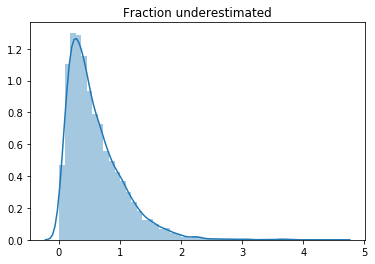

In [13]:
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
diffs = []
for i in top2top:
    temp = []
    for n in top2top[i]:
        if n<i:
            continue
        temp.append(top2top[i][n]['diff_score'])
    if len(temp)==0:
        continue
    diffs.append(np.mean(temp))

sns.distplot(diffs)
plt.title('Fraction underestimated')

/home/snorre/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'Fraction overestimated')

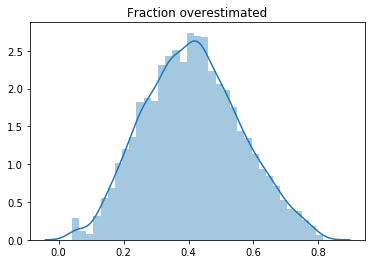

In [14]:
diffs = []
for i in top2top:
    temp = []
    for n in top2top[i]:
        if n>i:
            continue
        temp.append(top2top[i][n]['diff_score'])
    if len(temp)==0:
        continue
    diffs.append(np.mean(temp))

sns.distplot(diffs)
plt.title('Fraction overestimated')

In [15]:
clus = nx.clustering(top2top.to_undirected())

(array([ 40., 148., 436., 794., 980., 955., 883., 916., 761., 457.]),
 array([0.04751005, 0.14275905, 0.23800804, 0.33325704, 0.42850603,
        0.52375503, 0.61900402, 0.71425302, 0.80950201, 0.90475101,
        1.        ]),
 <a list of 10 Patch objects>)

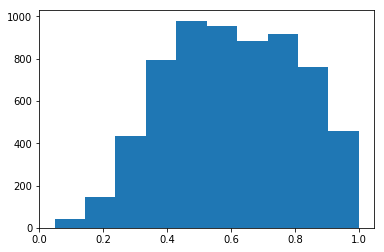

In [16]:
plt.hist(clus.values())

In [17]:
len(top2top.edges())

305760

In [408]:
#sum(subset.n_topics)

In [360]:
cos_mat.sum()#[num],num

0.0

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
top2top_un = top2top.to_undirected()
x,y = [top2top.in_degree(i) for i in sorted(top2top)],[top2top_un.degree(i) for i in sorted(top2top)]

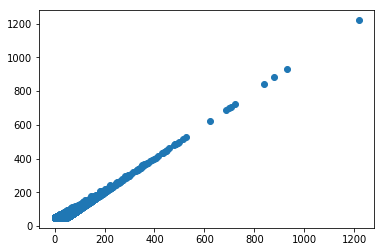

In [19]:
plt.scatter(x,y)

In [21]:
min(y),max(y),max(x)

(48, 1220, 1220)

(array([ 524.,  458.,  451.,  450.,  502.,  562.,  601.,  798.,  910.,
        1114.]),
 array([-1. , -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1,  0. ]),
 <a list of 10 Patch objects>)

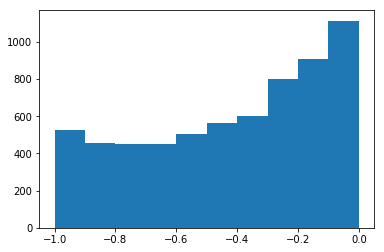

In [486]:
x,y = np.array(x),np.array(y)
plt.hist((x-y)/y)

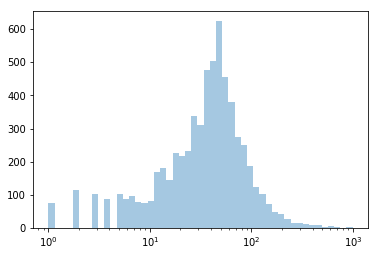

In [487]:
sns.distplot(x+1,bins=np.logspace(np.log10(min(x+1)),np.log10(max(x+1)), 50),kde=False)
plt.xscale('log')


#### Analysis of Hierachy: To what degree do Alligned Topics share lower level allignments.

In [22]:

                        
share = []
next_share = []
cos = []
max_cos = []
shares = []
for i in range(int(subset.n_topics.sum())):
    temp = []
    for n,d in top2top[i].items():
        w = d['weight']
        temp.append(w)
    cos.append(np.mean(temp))
    max_cos.append(max(temp))
    
    neighbors = sorted(list(top2top[i]))
    fracs = []
    try:
        next_ = sorted([n for n in neighbors if n>i])[0]
    except:
        continue
    s = set([n1 for n1 in neighbors if n1>next_])
    if len(s)==0:
        continue    
    neighbors2 = set([n1 for n1 in list(top2top[next_]) if n1>next_])
    frac = len(s&neighbors2)/len(s)
    next_share.append(frac)
    for n in neighbors:
        if n<i:
            continue
        s = set([n1 for n1 in neighbors if n1>n])
        
        if len(s)==0:
            continue
        neighbors2 = set([n1 for n1 in list(top2top[n]) if n1>n])
#        if len(s)==1:
#            print(s,neighbors2,neighbors[-2:],n,i)
        #print(len(neighbors2),len(s))
        frac = len(s&neighbors2)/len(s)
        #print(frac)
        fracs.append(frac)
    share.append(np.mean(fracs))
    shares.append(fracs)

size_model = np.concatenate([[sizes[i]]*sizes[i] for i in range(len(sizes))])

In [493]:
#plt.plot(share)

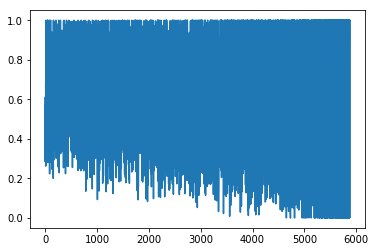

In [23]:

plt.plot(share)

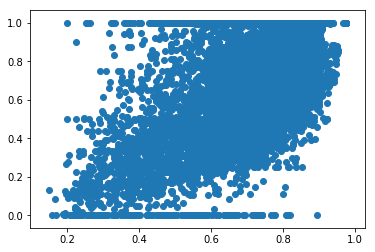

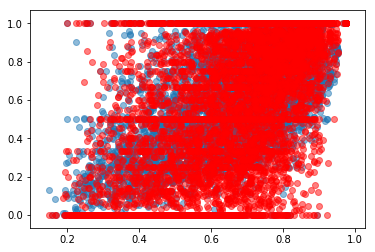

In [27]:
plt.scatter(cos[:len(next_share)],share,alpha=0.5)
plt.scatter(cos[:len(next_share)],next_share,color='r',alpha=0.5)

/home/snorre/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


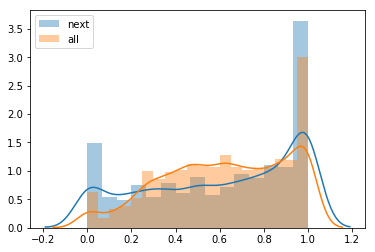

In [28]:
sns.distplot(next_share,label='next')
sns.distplot(share,label='all')
plt.legend()

In [519]:
#share

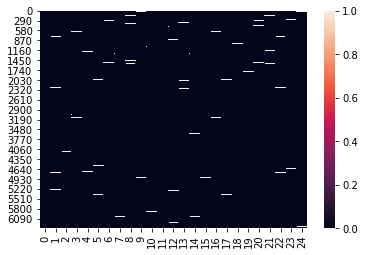

In [521]:
#list(map(len,shares))
top2top_mat = np.zeros((25,sum(subset.n_topics)))
for i in range(25):
    ns = top2top[i]
    for j in ns:
        top2top_mat[i,j] = 1
sns.heatmap(top2top_mat.T)

In [529]:
#top2top_mat.sum(axis=1)
top2top

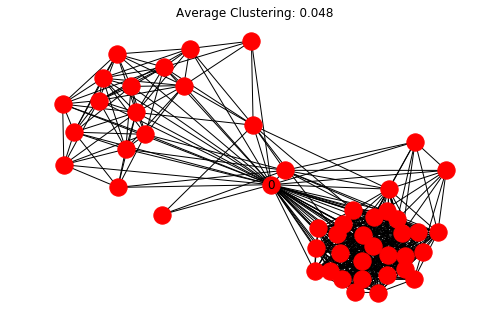

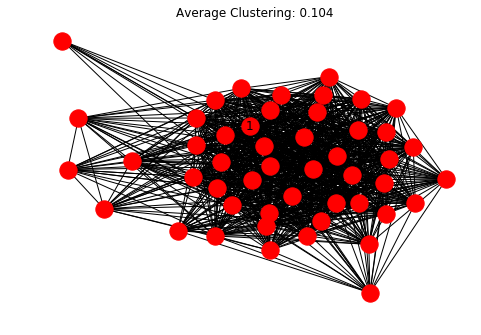

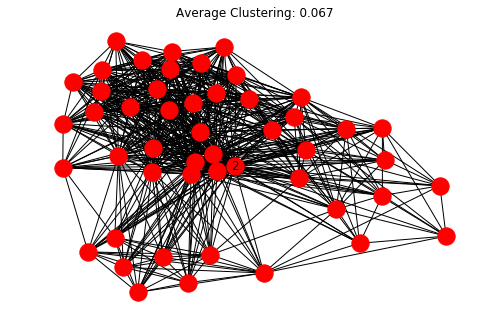

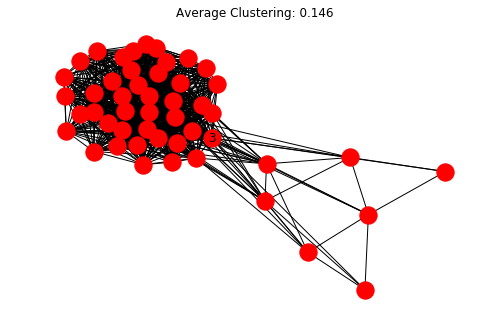

In [33]:
#def get_edges(n):    
    #if len(top2top[n])!=0:
     #   return
from tqdm import tqdm_notebook as tqdm
for i in tqdm(range(4)):
    sub = nx.Graph()
    ns = set(top2top[i])
    for n in ns:
        if n<i:
            continue
        sub.add_edge(i,n)
        for n2 in top2top[n]:
            if not n2 in ns:
                continue
            #if n2<n:
            #    continue
            sub.add_edge(n,n2)
    plt.figure()
    pos = nx.layout.spring_layout(sub)
    nx.draw(sub,pos)
    nx.drawing.draw_networkx_labels(sub.subgraph(nodes=[i]),{i:pos[i]})#(sub,pos=pos)
    plt.title('Average Clustering: %r'%(round(clus[i],3)))

### Hierarchy: Co-Lower-Topic graph.
For each topic we track the consistency of how higher level topics are bracketed together.

We can investigate if Collapsing happens consistently, at some threshold. I.e. a topic can be found at a lower level, with no higher level collapsing.



In [ ]:
for i in sorted(top2top):
    in_edges = 

In [229]:
t2model_size = dict(zip(range(len(size_model)),size_model))
same_edges = []
higher_level_edges = []
lower_level_edges = []
alone_sequences = []
density_sequences = []
conglomeration_sequences = []
for n in tqdm(sorted(top2top)):
    neighbors = top2top[n]
    s = t2model_size[n]
    alone_sequence = []
    densities = []
    conglomeration = []
    edges = []
    for n2 in sorted(neighbors):
        if n2>n: # look only at lower level
            break
        co_alligned = [i for i,j in top2top.in_edges(n2)]
        n_alligned = len([i for i in co_alligned if i in top2top_un[n]])
        if len(co_alligned) == 1:
            alone = 0
            density = np.nan
        else:
            alone = 1
            density = n_alligned/(len(co_alligned)-1)
        alone_sequence.append(len(co_alligned)-1)
        densities.append(density)
        same_count = 0
        temp_edges = []
        
        for co_n in co_alligned:
            if co_n==n:
                continue
            s2 = t2model_size[co_n]
            if s2==s:
                temp_edges.append(co_n)
                same_count+=1
                continue
        #    if s2>s:
        #        higher_level_edges.append((n,co_n,n2))
        #    else:
        #        lower_level_edges.append((n,co_n,n2))
        conglomeration.append(same_count)
        edges.append(temp_edges)
    alone_sequences.append(alone_sequence)
    density_sequences.append(densities)
    conglomeration_sequences.append(conglomeration)
    same_edges.append(edges)
#in_degree = top2top.in_degree()

#x,y = zip(*sorted(list(in_degree)))
#plt.plot(x,np.array(y)/size_model[::-1])

Text(0.5,0,'K-topics')

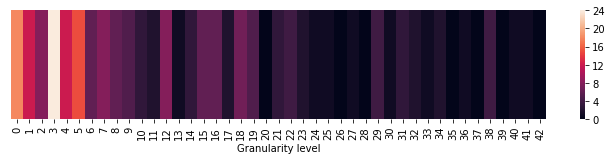

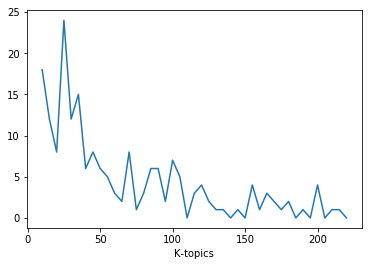

In [179]:
import random
seq = np.array([20])
while sum(seq==0)<5:
    i = random.choice(range(len(conglomeration_sequences)))
    seq = np.array(conglomeration_sequences[i])
plt.figure(figsize=(12,2))
ax = sns.heatmap(np.array(seq).reshape(1,-1))
plt.xlabel('Granularity level')
ax.set_yticks([]);
plt.figure()
plt.plot(sizes[0:len(seq)],seq)
plt.xlabel('K-topics')

The above shows a trajectory of a given high level topic, in relation to how subtopic neighbors have been conglemerated at each "Granularity" level. 

** Conglomeration is not consistently related to Choice of "Granularity" Level.** 

Otherwise we should have seen a consistent decline as granularity is heighened.

In [193]:
len(same_edges),len(top2top.edges()),len(higher_level_edges),len(lower_level_edges)

(712524, 305760, 13027952, 15530929)

In [195]:
len(same_edges),len(top2top.edges())

(6370, 305760)

In [188]:
def make_ego_graph(n):
    edges = same_edges[n]
    
last = same_edges[0][0]
ego = nx.Graph()
n = 6100
edges = same_edges[n]
for level_num,temp_edges in enumerate(edges):
    
    try:
        ego[n][n2]['weight'] +=1
    except:
        ego.add_edge(n,n2,weight=1)
    

In [192]:
sum([d['weight'] for n,n2,d in ego.edges(data=True)])

108

## visualize subtopical conglemeration as a heatmap


In [238]:
! mkdir output/conglomeration

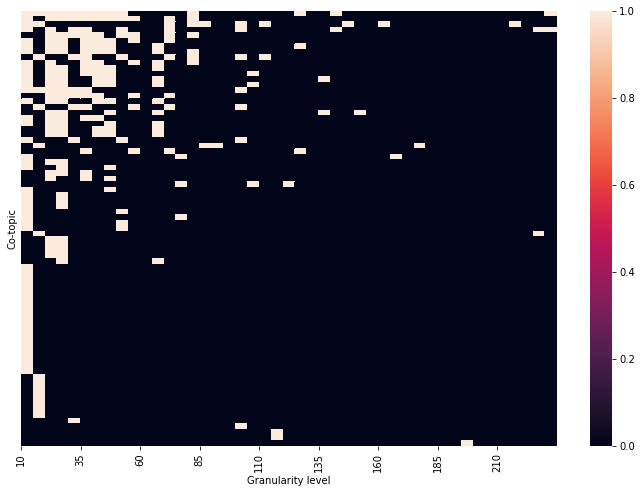

In [243]:
from collections import Counter
def get_edge_counts(n):
    edges = same_edges[n]
    neighbors = Counter()
    for level in edges:
        for n in level:
            neighbors[n]+=1
    return neighbors
def make_neighbor_index(n):
    neighbors = get_edge_counts(n)
    n2idx = {n:num for num,n in enumerate(sorted(neighbors,key=lambda x: neighbors[x],reverse=True))}
    return n2idx
def make_co_topic_matrix(n):
    n2idx = make_neighbor_index(n)
    edges = same_edges[n]
    mat = np.zeros((len(n2idx),len(edges)))
    for num,level in enumerate(edges):
        for n in level:
            idx = n2idx[n]
            mat[idx,num] = 1
    return mat
n = random.choice(list(top2top))
s = t2model_size[n]
xticks = [i for i in sizes if i<s]
mat = make_co_topic_matrix(n)
fig = plt.figure(figsize=(12,8))
ax = sns.heatmap(mat)
plt.xlabel('Granularity level')
plt.ylabel('Co-topic')
ax.set_yticks([])
ax.set_xticks(np.arange(len(xticks))[::5])
ax.set_xticklabels(xticks[::5]);
fig.savefig('output/conglomeration/co_topic_matrix_%d'%(n))

** If we could really assume hierachical conglemeration, then we should have observed a matrix with active cells in the upper part, gradually allowing more loosely associated clusters to be incorporated. Furthermore we should observe that once a topic has been conglemerated with another topic at a certain level of granularity, it should also be active in the next level ofgranularity. So rows should be consistently active, from a certain starting point in granularity.**



In [255]:
#plt.plot(next_share)
#next_share

In [234]:
share = []
next_share = []
for i in reversed(range(int(subset.n_topics.sum()))):
    neighbors = sorted(list(top2top[i]),reverse=True)
    fracs = []
    try:
        next_ = max([n for n in neighbors if n<i])
    except:
        continue
    s = set([n1 for n1 in neighbors if n1<next_])
    if len(s)==0:
        continue    
    neighbors2 = set([n1 for n1 in list(top2top[next_]) if n1<next_])
    frac = len(s&neighbors2)/len(s)
    next_share.append(frac)
    for n in neighbors:
        if n>i:
            continue
        s = set([n1 for n1 in neighbors if n1<n])
        
        if len(s)==0:
            continue
        neighbors2 = set([n1 for n1 in list(top2top[n]) if n1<n])
#        if len(s)==1:
#            print(s,neighbors2,neighbors[-2:],n,i)
        #print(len(neighbors2),len(s))
        frac = len(s&neighbors2)/len(s)
        #print(frac)
        fracs.append(frac)
    share.append(np.mean(fracs))
    #print(1+'2')

TypeError: unsupported operand type(s) for +: 'int' and 'str'

In [270]:
#max_cos

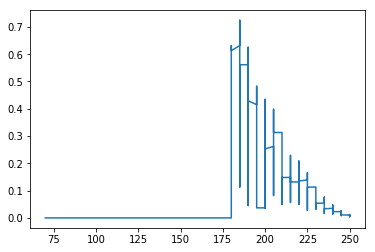

In [225]:
import pandas as pd
plt.plot(size_model[:len(next_share)],pd.Series(next_share).rolling(window=50).mean())

In [ ]:
size_model = np.concatenate([[sizes[i]]*sizes[i] for i in range(len(sizes))])[::-1]
tempdf = pd.DataFrame({'size':size_model[:len(next_share)],'share':share,'next_share':next_share})

In [272]:
size_model = np.concatenate([[sizes[i]]*sizes[i] for i in range(len(sizes))])[::-1]
tempdf = pd.DataFrame({'size':size_model[-len(next_share):],'share':share,'next_share':next_share,'cos':cos[-len(next_share):],'max_cos':max_cos[-len(next_share):]})

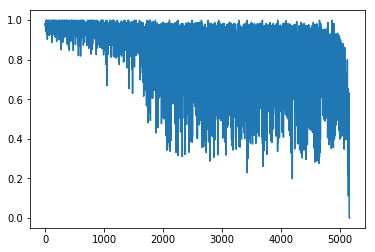

In [275]:
tempdf.max_cos.plot()

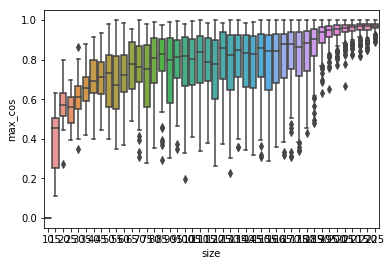

In [276]:
sns.boxplot(x='size',y='max_cos',data=tempdf)

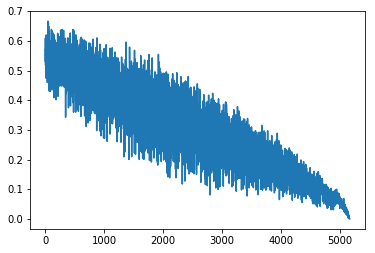

In [264]:
tempdf.cos.plot()

In [278]:
#tempdf.groupby('size').median()

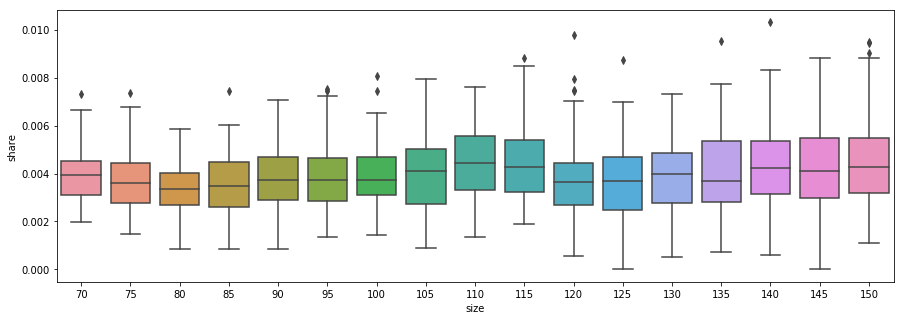

In [228]:
plt.figure(figsize=(15,5))
sns.boxplot(x='size',y='share',data=tempdf[tempdf['size']<=150])

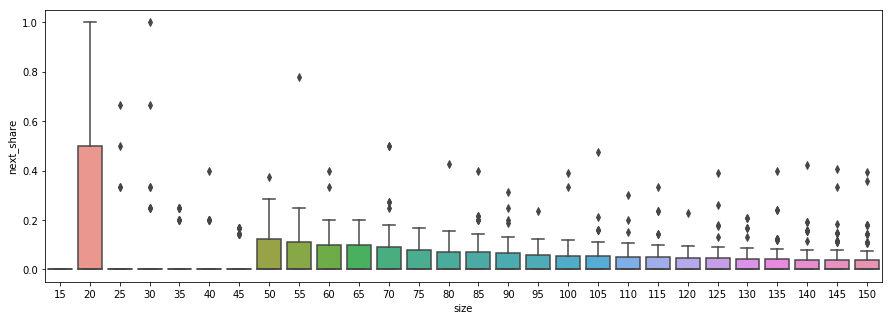

In [212]:
plt.figure(figsize=(15,5))
sns.boxplot(x='size',y='next_share',data=tempdf[tempdf['size']<=150])

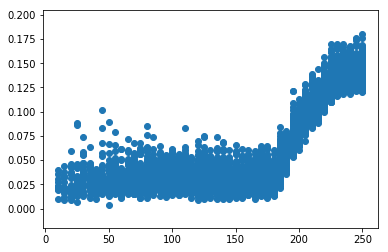

In [170]:
size_model = np.concatenate([[sizes[i]]*sizes[i] for i in range(len(sizes))])[::-1]
plt.scatter(size_model,share)

In [162]:
n

9

array([ 10,  10,  10, ..., 250, 250, 250])

In [130]:
min(x),len(paths)

(48, 49)

In [123]:
np.argsort(y)[-1]

3324

In [113]:
#top2top.degree()

In [21]:
t2w2 = data2[1].toarray()
j_len = t2w2.shape[0]
cos_mat = 1 - scipy.spatial.distance.cdist(t2w, t2w2, 'cosine')

(10, 15, (10, 15))

In [77]:
scipy.spatial.distance.cdist(t2w, t2w2, 'cosine').shape

(15, 20)

In [81]:
t2w.shape,t2w2.shape,cos_mat.shape,cos_mat.T.shape

((15, 32397), (20, 32397), (15, 20), (20, 15))

In [85]:
i_len,j_len,i_topics,j_topics,j_topics+j_len,sum(subset.n_topics)

(15, 20, 10, 6360, 6380, 6370)

In [86]:
6370*6730

42870100

In [87]:
sizes = subset.n_topics.values

In [90]:
for i in tqdm(range(len(paths))):
    path = paths[i]
    data = load_data(path)
    t2w = data[1].toarray()
    i_len = t2w.shape[0]
    size = sizes[i]
    if size!=i_len:
        print('what')

In [120]:
data[0].shape

(46209, 250)

In [133]:
dot = t2w.dot(t2w2.T)
dot / (t2w.dot(t2w2.T)+t2w.dot(t2w2.T))/2 

matrix([[0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25,
         0.25, 0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25,
         0.25, 0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25,
         0.25, 0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25,
         0.25, 0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25,
         0.25, 0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25,
         0.25, 0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25,
         0.25, 0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25,
         0.25, 0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25,
         0.25, 0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25

array([[0.36704185, 0.29566496, 0.05986255, 0.90281791, 0.44846062,
        0.38580167, 0.49136298, 0.23060327, 0.43219217, 0.45451184,
        0.29310724, 0.65740818, 0.36281545, 0.51266574, 0.311767  ],
       [0.9711357 , 0.47977411, 0.03422115, 0.3624174 , 0.46750166,
        0.43475228, 0.33910413, 0.27683496, 0.38803694, 0.42364189,
        0.30016366, 0.37486587, 0.36988811, 0.50459693, 0.40467571],
       [0.15496927, 0.11988075, 0.45970609, 0.26253479, 0.25808701,
        0.14485314, 0.10134696, 0.14005638, 0.14737506, 0.21033324,
        0.11167991, 0.11737845, 0.86995969, 0.30317077, 0.17556003],
       [0.24897725, 0.23408695, 0.02582689, 0.28473575, 0.31571354,
        0.38598641, 0.78764762, 0.21241823, 0.34163886, 0.34618394,
        0.90660244, 0.27424302, 0.1940248 , 0.25022478, 0.32871869],
       [0.34826032, 0.27687214, 0.03643703, 0.4408388 , 0.36558982,
        0.42506984, 0.4215764 , 0.58545573, 0.96548409, 0.57684291,
        0.34845186, 0.31087851, 0.25627675, 

In [147]:
self1 = np.diag(t2w.dot(t2w.T).toarray())
self2 = np.diag(t2w2.dot(t2w2.T).toarray())
self2

array([0.00207739, 0.00213273, 0.00362821, 0.00132567, 0.00156953,
       0.00131766, 0.00227526, 0.00176934, 0.0012285 , 0.00179833,
       0.00231607, 0.00076073, 0.00332784, 0.00281818, 0.00167311])

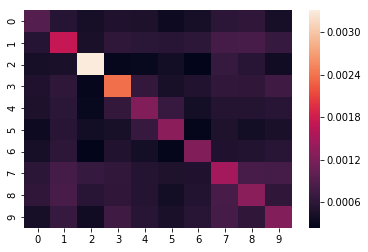

In [149]:
import seaborn as sns
%matplotlib inline
sns.heatmap(t2w.dot(t2w.T).toarray())

In [142]:
dot

<10x15 sparse matrix of type '<class 'numpy.float64'>'
	with 150 stored elements in Compressed Sparse Row format>

In [130]:
t2w2.dot(t2w2.T)

<15x15 sparse matrix of type '<class 'numpy.float64'>'
	with 225 stored elements in Compressed Sparse Row format>